## 特征工程

特征工程第一步：理解业务

### （一）特征提取

从文字、图像、声音等其他非结构化数据中提取新信息作为特征。比如，从淘宝宝贝的名称中提取出产品类别，产品颜色，是否是网红产品等。

### （二）特征创造（降维算法：见下章）

把现有特征进行组合或相互计算，得到新的特征。比如，一列特征是速度，一列特征是距离，让两列相除获得通过距离所花的时间。

### （三）特征选择（本章重点）

从所有特征中，选择出有意义、对模型有帮助的特征，以避免必须将所有特征都导入模型去训练的情况。

In [1]:
#导入数据
import pandas as pd
data = pd.read_csv('04digit recognizor.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
X = data.iloc[:,1:]
y =data.iloc[:,0]

In [3]:
X.shape

(42000, 784)

## 一、Filter过滤法

过滤方法通常用作预处理步骤，特征选择完全独立于任何机器学习算法。它是根据各种**统计检验中的分数**以及**相关性的各项指标**来选择特征。

全部特征→最佳特征子集→算法→模型评估

### （一）方差过滤：优先消除方差为0或很小的特征

如果一个特征本身的方差很小，那这个特征对于样本区分没有什么作用。

**1.sklearn.feature_selection.VarianceThreshold**

In [4]:
from sklearn.feature_selection import VarianceThreshold

（1）阈值threshold是0（默认）：删掉了784-708个特征

In [5]:
selector = VarianceThreshold() #实例化，不填参数默认方差为0
X_var0 = selector.fit_transform(X) #获取删除不合格特征之后的新特征矩阵
X_var0.shape

(42000, 708)

In [6]:
pd.DataFrame(X_var0).head()

,0,1,2,3,4,5,6,7,8,9,...,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


（2）阈值threshold是特征方差的中位数：删掉了784-392（一半）个特征

In [7]:
#查看所有特征的方差的中位数
import numpy as np
np.median(X.var().values)

1352.286703180131

In [8]:
#删除方差小于中位数的特征
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)

In [9]:
X_fsvar.shape

(42000, 392)

（3）阈值threshold是二分类特征中某种分类占到80%以上的方差：删掉了784-685个特征

当特征是二分类时，特征的取值就是伯努利随机变量，这些变量的方差可以计算为：p(1-p)。

In [10]:
#若特征是伯努利随机变量，假设p=0.8，即二分类特征中某种分类占到80%以上的时候删除特征
X_bvar = VarianceThreshold(0.8*(1-0.8)).fit_transform(X)

In [11]:
X_bvar.shape

(42000, 685)

**2.方差过滤对模型的影响**（阈值为特征方差的中位数）

（1）导入模块并准备数据

In [12]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
import numpy as np

In [13]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
x_fsvar = X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)

（2）KNN

①KNN方差过滤前

②KNN方差过滤后

（3）随机森林

①随机森林方差过滤前

In [14]:
cross_val_score(RFC(n_estimators=10,random_state=0),X,y,cv=5).mean()

0.9373571428571429

In [15]:
%%timeit
cross_val_score(RFC(n_estimators=10,random_state=0),X,y,cv=5).mean()

32.9 s ± 2.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


②随机森林方差过滤后

In [16]:
cross_val_score(RFC(n_estimators=10,random_state=0),X_fsvar,y,cv=5).mean()

0.9390476190476191

In [17]:
%%timeit
cross_val_score(RFC(n_estimators=10,random_state=0),X_fsvar,y,cv=5).mean()

22.5 s ± 5.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


方差过滤后：<br>
（1）KNN：准确率增加0.014%，运行时间减少14分钟；<br>
（2）随机森林：准确率增加0.17%，运行时间减少10.1s。<br>
因此，过滤法的主要对象是需要**遍历特征**或**升维**的算法，如最近邻KNN、单棵决策树、支持向量机SVM、神经网络、回归。<br>
从算法原理上来说，传统决策树需要**遍历所有特征**，计算不纯度后进行分支，而随机森林却是**随机选择特征**进行计算和分枝，因此随机森林的运算更快，因此过滤法对随机森林无用，对决策树有用。

### （二）相关性过滤

**1.卡方过滤**：针对离散型标签，即分类问题。

卡方检验类`feature_selection.chi2`计算每个**非负特征和标签**之间的卡方统计量，并依照卡方统计量**由高到低**为特征排名。再结合`feature_selection.SelectKBest`类，它可以输入“评分标准”选出前K个分数最高的特征。

In [18]:
from sklearn.ensemble import RandomForestClassifier as RFC #以随机森林为例做特征选择
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.feature_selection import SelectKBest #选择前K个分数最高的特征
from sklearn.feature_selection import chi2 #卡方检验

In [19]:
#假设需要300个特征
X_fschi = SelectKBest(chi2, k=300).fit_transform(X_fsvar,y) #第一个参数：模型依赖的统计量；第二个参数：选前k个卡方值最高的特征
X_fschi.shape

(42000, 300)

In [20]:
#验证模型效果
cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

0.9344761904761905

效果降低了，说明设定k=300时删除了与模型有关且有效的特征。

**选取超参数k**

（1）学习曲线

In [21]:
import matplotlib.pyplot as plt

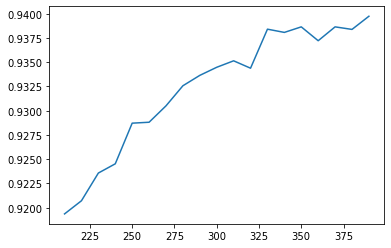

In [22]:
score = []
for i in range(390,200,-10):
    x_fschi = SelectKBest(chi2, k=i).fit_transform(X_fsvar,y)
    once = cross_val_score(RFC(n_estimators=10, random_state=0),x_fschi,y,cv=5).mean()
    score.append(once)
plt.plot(range(390,200,-10),score)

随着K值不断增加，模型的表现不断上升，这说明，K值越大越好，数据中所有的特征都是与标签相关的。

（2）根据卡方统计量的p值选择k：选取p值小于0.05的特征

In [23]:
chivalue, pvalues_chi = chi2(X_fsvar,y) #参数：特征矩阵、标签

In [24]:
chivalue

array([ 945664.84392643, 1244766.05139164, 1554872.30384525,
       1834161.78305343, 1903618.94085294, 1845226.62427198,
       1602117.23307537,  708535.17489837,  974050.20513718,
       1188092.19961931, 1319151.43467036, 1397847.8836796 ,
       1433554.26798015, 1429043.15373433, 1332663.17213405,
       1101423.25372261,  809989.56940485,  519266.71772284,
        285681.88297156,  191589.23696468,  902883.1255264 ,
       1237265.16042373, 1503477.73699155, 1625807.41495542,
       1630206.90922916, 1630597.02883804, 1633456.72909664,
       1610816.75571229, 1483382.49543886, 1256290.1574794 ,
        951236.1617682 ,  693192.66191748,  532386.96220361,
        504617.38933715,  575090.36046243,  501025.03733245,
        802341.10683194, 1078344.8724406 , 1226540.98318702,
       1269945.07968831, 1221758.57688808, 1146535.17810241,
       1080657.20185303, 1079065.30979135, 1092222.70610032,
       1064908.45385716, 1023327.00231067,  974163.15420165,
        918857.12860617,

In [25]:
pvalues_chi #这些特征都和标签相关

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [26]:
k = chivalue.shape[0] - (pvalues_chi > 0.05).sum() #k=特征数量-想减去的特征的数量
k

392

根据卡方统计量的p值确定k=392。

**2.F检验（线性）**

F检验，即方差齐性检验，是用来捕捉每个特征与标签之间的**线性关系**的过滤方法。F检验分类`sklearn.feature_selection.f_classif`用于标签是**离散型**变量的数据，F检验回归`sklearn.feature_selection.f_regression`用于标签是**连续型**变量的数据。

In [27]:
from sklearn.feature_selection import f_classif

（1）学习曲线

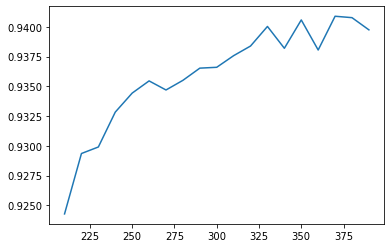

In [28]:
score = []
for i in range(390,200,-10):
    x_fsF = SelectKBest(f_classif, k=i).fit_transform(X_fsvar,y)
    once = cross_val_score(RFC(n_estimators=10, random_state=0),x_fsF,y,cv=5).mean()
    score.append(once)
plt.plot(range(390,200,-10),score)

（2）根据F统计量的p值选择k：选取p值小于0.05的特征

In [29]:
F, pvalues_f = f_classif(X_fsvar,y)

In [30]:
F

array([ 618.65383492,  846.18897012, 1115.40617051, 1362.3677305 ,
       1452.03355369, 1381.09095571, 1138.26505266,  464.29616121,
        660.00977785,  849.66393412, 1004.7450309 , 1124.76177588,
       1200.99190762, 1209.29489877, 1110.4944286 ,  854.66183292,
        577.52063451,  342.09729054,  178.67397866,  118.01145533,
        612.12261014,  899.40904291, 1196.17528948, 1424.49864852,
       1569.26556677, 1742.49910702, 1910.98023795, 1969.20520223,
       1731.37475948, 1295.09668012,  839.15325001,  531.97951763,
        371.82392681,  336.00820537,  378.93378743,  317.47025479,
        528.94881012,  766.40792176,  947.63168717, 1086.0472161 ,
       1177.72017709, 1253.79641973, 1344.06961068, 1507.33781169,
       1616.50454434, 1512.25864876, 1289.65180587, 1051.26276412,
        839.48869386,  680.07426932,  600.85538567,  633.55772663,
        683.96908509,  347.65867784,  452.76238211,  509.16387684,
        515.7498157 ,  532.86107778,  594.62512658,  664.18740

In [31]:
pvalues_f

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 4.71193533e-220,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [32]:
k = F.shape[0] - (pvalues_f > 0.05).sum()
k

392

根据F统计量的p值确定k=392。

**3.互信息法（线性+非线性）**

互信息法用来捕捉每个特征与标签之间的任意关系（包括**线性和非线性**关系）的过滤方法，`sklearn.feature_selection.mutual_info_classif`用于互信息**分类**，`sklearn.feature_selection.mutual_info_regression`用于互信息**回归**。互信息法不返回p值或F值类似的统计量，它返回**每个特征和目标之间的互信息量的估计**，这个估计量在[0,1]之间取值，为**0**则表示两个变量**独立**，为**1**则表示两个变量**完全相关**。

In [33]:
from sklearn.feature_selection import mutual_info_classif as MIC

（1）学习曲线

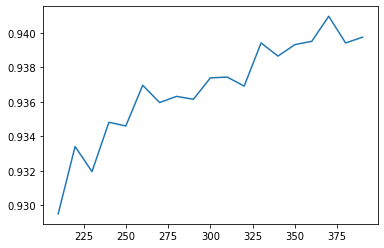

In [34]:
score = []
for i in range(390,200,-10):
    x_fsmic = SelectKBest(MIC, k=i).fit_transform(X_fsvar,y)
    once = cross_val_score(RFC(n_estimators=10, random_state=0),x_fsmic,y,cv=5).mean()
    score.append(once)
plt.plot(range(390,200,-10),score)

（2）根据互信息量选择k：选取互信息量大于0的特征

In [35]:
result = MIC(X_fsvar,y) #参数：特征矩阵，标签

In [36]:
result #每个特征与目标之间的互信息量的估计

array([0.0650104 , 0.08426526, 0.09742239, 0.11550521, 0.11691636,
       0.10415005, 0.08488675, 0.05662605, 0.08176214, 0.09965716,
       0.1167988 , 0.13748926, 0.16316366, 0.16614488, 0.15951659,
       0.12683727, 0.09885788, 0.06357939, 0.04003084, 0.02717691,
       0.07120253, 0.09609901, 0.1180124 , 0.15015503, 0.17551452,
       0.20276118, 0.22639214, 0.23543282, 0.21866957, 0.18145266,
       0.14753337, 0.10824114, 0.08103158, 0.05736206, 0.04880497,
       0.02669239, 0.06039764, 0.07901721, 0.10372783, 0.1185905 ,
       0.13546562, 0.14594766, 0.16305275, 0.17859042, 0.18656156,
       0.17132796, 0.15261868, 0.12890553, 0.11399748, 0.09881192,
       0.07807477, 0.0711158 , 0.05849101, 0.04987486, 0.05774976,
       0.07206816, 0.09018727, 0.09266322, 0.10777826, 0.10753331,
       0.10663969, 0.1151975 , 0.11929936, 0.12362709, 0.10682413,
       0.10957077, 0.11368341, 0.11089696, 0.09139497, 0.08103074,
       0.06928067, 0.03664856, 0.05340734, 0.06318892, 0.07864

In [37]:
(result > 0).sum()

392

In [38]:
k = result.shape[0] - sum(result <= 0)
k

392

根据互信息量确定k=392。

In [39]:
X_fsF = SelectKBest(f_classif, k=392).fit_transform(X_fsvar,y) #第一个参数：模型依赖的统计量；第二个参数：选前k个卡方值最高的特征
cross_val_score(RFC(n_estimators=10,random_state=0),X_fsF,y,cv=5).mean()

0.9390476190476191

**过滤法总结**：先使用方差过滤，再使用相关性过滤中的互信息法捕捉相关性。

## 二、Embedded嵌入法（运行慢）

特征选择和算法训练同时进行。在使用嵌入法`sklearn.feature_selection.SelectFromModel`时，先使用某些机器学习的算法和模型进行训练，得到各个特征的**权值系数**（代表特征对于模型的某种贡献或某种重要性），根据权值系数从大到小选择特征。但是权值系数**很难界定**有效的临界值（p=0.05），只能说权值系数为0的特征对模型丝毫没有作用，此时模型权值系数就是超参数，需要根据**学习曲线**或**模型本身**的某些性质去判断超参数的最佳值。

In [40]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC

In [41]:
RFC_ = RFC(n_estimators=10,random_state=0) #随机森林的实例化

In [42]:
#使用原始的特征矩阵
X_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(X,y) #嵌入法的实例化（参数：实例化后的算法；低于该阈值的特征将被删除，阈值在0到1之间波动）

In [43]:
X_embedded.shape #删掉了784-47=733个特征

(42000, 47)

**画一个简单的学习曲线确定最佳阈值**

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
RFC_.fit(X,y).feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.96726660e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.39623410e-06,
       7.35101726e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.70425050e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.09114204e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [46]:
(RFC_.fit(X,y).feature_importances_).max() #学习曲线x轴的最大值

0.01276360214820271

In [47]:
threshold = np.linspace(0,(RFC_.fit(X,y).feature_importances_).max(),20)
threshold #学习曲线x轴刻度

array([0.        , 0.00067177, 0.00134354, 0.00201531, 0.00268707,
       0.00335884, 0.00403061, 0.00470238, 0.00537415, 0.00604592,
       0.00671769, 0.00738945, 0.00806122, 0.00873299, 0.00940476,
       0.01007653, 0.0107483 , 0.01142007, 0.01209183, 0.0127636 ])

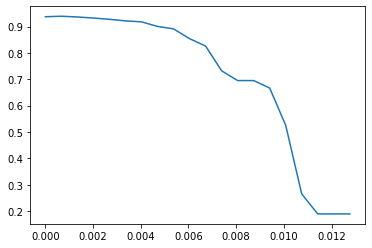

In [48]:
score = []
for i in threshold:
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score.append(once)
plt.plot(threshold,score)

从图像上来看，随着阈值越来越高，模型的效果逐渐变差，被删除的特征越来越多，信息损失也逐渐变大。但是在0.00134之前，模型的效果都可以维持在0.93以上，因此可以从中挑选一个数值（如0.00067）来验证一下模型的效果。

In [49]:
X_embedded = SelectFromModel(RFC_,threshold=0.00067).fit_transform(X,y)
X_embedded.shape

(42000, 324)

In [50]:
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9391190476190475

特征少了，分数却变高了（93.90476），这是由于嵌入法比方差过滤更具体到模型的表现的缘故，换一个算法，使用同样的阈值，效果可能就没有这么好了。

**画一个细化的学习曲线找到最佳阈值。**

([<matplotlib.axis.XTick at 0x293a110ae80>,
 <a list of 20 Text major ticklabel objects>)

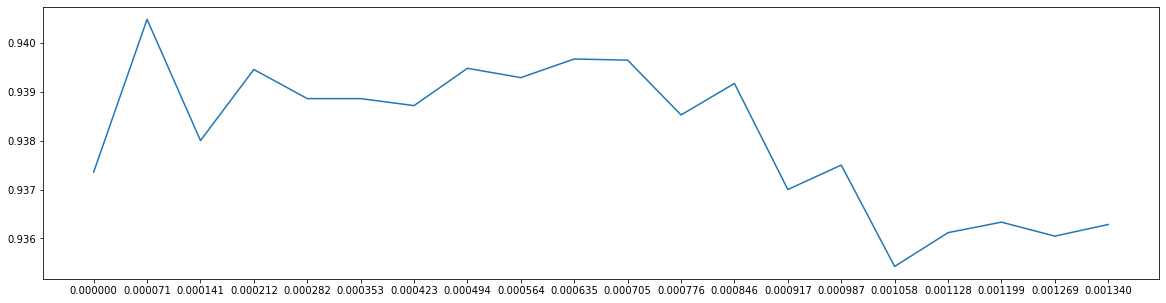

In [51]:
score2 = []
for i in np.linspace(0,0.00134,20):
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score2.append(once)
plt.figure(figsize=[20,5])
plt.plot(np.linspace(0,0.00134,20),score2)
plt.xticks(np.linspace(0,0.00134,20))

选取最佳阈值0.000071。

In [52]:
X_embedded = SelectFromModel(RFC_,threshold=0.000071).fit_transform(X,y)
X_embedded.shape

(42000, 461)

In [53]:
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9388809523809524

In [54]:
#重新实例化随机森林，跑100颗树，效果更好
cross_val_score(RFC(n_estimators=100,random_state=0),X_embedded,y,cv=5).mean()

0.964642857142857

用n_estimators画一条学习曲线，可能效果会更好。

**嵌入法总结**：减少计算量，提升模型表现。但在大型数据中，优先考虑过滤法。

## 三、Wrapper包装法（运行慢）

包装法`sklearn.feature_selection.RFE`也是一个**特征选择**和**算法训练**同时进行的方法，与嵌入法十分相似，它也是依赖于算法自身的选择。但不同的是，我们往往使用一个**目标函数**（递归特征消除法RFE）作为黑盒来帮助我们选取特征，而不是自己输入某个评估指标或统计量的阈值。

In [55]:
from sklearn.feature_selection import RFE

In [56]:
#随机森林实例化
RFC_ = RFC(n_estimators=10,random_state=0)
#包装法实例化，假设留下340个特征，每迭代一次移除50个特征
selector = RFE(RFC_,n_features_to_select=340,step=50).fit(X,y)

In [57]:
selector.support_ #True是留下的特征

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,

In [58]:
selector.support_.sum()

340

In [59]:
selector.ranking_ #特征重要性排序

array([10,  9,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  6,  6,
        5,  6,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  5,  4,
        4,  5,  3,  4,  4,  4,  5,  4,  5,  7,  6,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  7,  4,  3,  1,  2,  3,  3,  1,  1,  1,  1,
        1,  3,  3,  4,  5,  5,  5,  8,  8,  9,  9,  9,  9,  8,  9,  9,  4,
        4,  3,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  4,
        5,  5,  9,  9, 10, 10, 10, 10,  7,  4,  4,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  5,  8, 10, 10, 10,
       10,  9,  4,  4,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  4, 10, 10, 10, 10,  9,  7,  4,  3,  2,  2,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        4,  4, 10,  9, 10

In [60]:
X_wrapper = selector.transform(X) #使用包装法得到的特征矩阵
cross_val_score(RFC_,X_wrapper,y,cv=5).mean()

0.9379761904761905

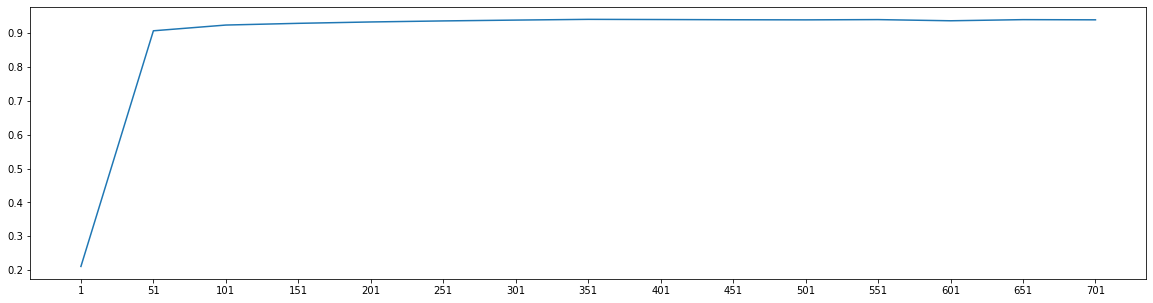

In [61]:
#画n_features_to_select的学习曲线
score = []
for i in range(1,751,50):
    X_wrapper = RFE(RFC_,n_features_to_select=i,step=50).fit_transform(X,y)
    once = cross_val_score(RFC_,X_wrapper,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,751,50),score)
plt.xticks(range(1,751,50))
plt.show()

包装法是最容易在最少特征数量下找到最佳模型表现的方法。50个特征时，模型的表现就已经达到了90%以上，比嵌入发和过滤法都高效很多。

## 特征选择总结

经验来说，**过滤法**更快速，但更粗糙。**包装法**和**嵌入法**更精确，比较适合具体到算法去调整，但计算量比较大，运行时间长。当**数据量很大**的时候，优先使用**方差过滤**和**互信息法**调整，再上其他特征选择方法。使用**逻辑回归**时，优先使用**嵌入法**。使用**支持向量机**时，优先使用**包装法**。迷茫的时候，从**过滤法**走起，看具体数据具体分析。其实特征选择只是特征工程中的第一步。真正的高手，往往使用**特征创造**或**特征提取**来寻找高级特征。